# Music Genre Classification using SVM

This notebook implements an SVM classifier for the GTZAN music dataset with 10 genres.

### Architecture

from paper [link](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=10605044)
```txt
G. ARCHITECTURE OF SVM MODEL
In our study, the SVM architecture is described in the obtained
Mel-Frequency Cepstral Coefficients (MFCC) features of au-
dio samples for music genre classification. Initially, the audio
files are sampled at a rate of 22,050 Hz, and each track is
divided into numerous parts lasting 30 seconds each. MFCC
features are then computed for each segment via the librosa
package. The generated MFCC vectors are flattened into one-
dimensional arrays and divided into training and testing sets.
Changsheng et al. [32] propose effective algorithms to auto-
matically classify and summarize music content, and SVM is
used to classify music. Selecting the hyperplane in the feature
space that best divides several classes is the foundation of
SVMs, as opposed to neural networks. A linear SVM model
is trained on the training set using the sci-kit-learn library’s
SVC class, with the regularization parameter (C) set to one.
Subsequently, the trained model is used to predict genre labels
for the test set. The accuracy-score function from sci-kit-learn
is used to evaluate the SVM model’s performance in classi-
fying music genres. This architecture shows the process of
feature extraction, model training, prediction, and evaluation
in SVM-based music genre classification, with a focus on the
audio sample rate and track duration parameters.
```

### First thoughts

RBF outperforms linear

We got worse results than paper

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../data/processed/processed_dataset.csv')

# Separate features and target
# TODO: Check with less features (MFCC 13-20 only)
X = df.drop('Y', axis=1)
y = df['Y']

# Dataset has no labels but first 0-99 is the first genre and so on
genres = ['blues', 'classical', 'country', 'disco', 'hiphop', 
          'jazz', 'metal', 'pop', 'reggae', 'rock']

# Scale the features
# wit only mfcc might be omitted?
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split to 20 / 80 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [3]:
# In paper there is only C = 1 with linear kernel
# I want to test other regularization values and rbf kernel
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.1, 1]
}

svm = SVC(random_state=42)

grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best cross-validation score: 0.7474999999999999


In [8]:
# Print all GridSearchCV results
results = pd.DataFrame(grid_search.cv_results_)
print("All parameter combinations and their scores:")
for idx, row in results.iterrows():
    print(f"\nParameters: {row['params']}")
    print(f"Mean CV Score: {row['mean_test_score']:.4f}")
    print(f"Std CV Score: {row['std_test_score']:.4f}")
    print(f"Rank: {row['rank_test_score']}")
    print("-" * 50)

All parameter combinations and their scores:

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Mean CV Score: 0.7200
Std CV Score: 0.0260
Rank: 7
--------------------------------------------------

Parameters: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf'}
Mean CV Score: 0.5300
Std CV Score: 0.0207
Rank: 26
--------------------------------------------------

Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'linear'}
Mean CV Score: 0.7200
Std CV Score: 0.0260
Rank: 7
--------------------------------------------------

Parameters: {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Mean CV Score: 0.5300
Std CV Score: 0.0207
Rank: 26
--------------------------------------------------

Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Mean CV Score: 0.7200
Std CV Score: 0.0260
Rank: 7
--------------------------------------------------

Parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
Mean CV Score: 0.1200
Std CV Score: 0.0275
Rank: 31
--------------------------------------

Classification results:
              precision    recall  f1-score   support

       blues       0.76      0.80      0.78        20
   classical       0.86      0.92      0.89        13
     country       0.74      0.74      0.74        27
       disco       0.74      0.67      0.70        21
      hiphop       0.57      0.87      0.68        15
        jazz       0.90      0.82      0.86        22
       metal       0.81      0.88      0.85        25
         pop       0.67      0.62      0.64        13
      reggae       0.60      0.39      0.47        23
        rock       0.64      0.67      0.65        21

    accuracy                           0.73       200
   macro avg       0.73      0.74      0.73       200
weighted avg       0.73      0.73      0.73       200

SVM scores from paper
SVM    0.81    N/A    0.80 N/A


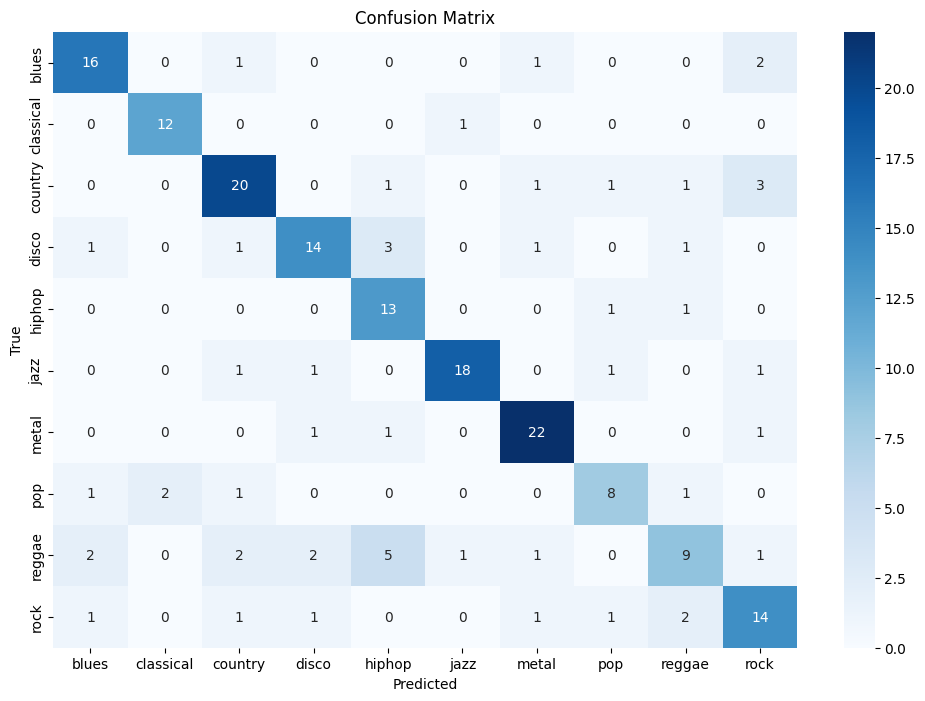

In [7]:
# Get predictions using best model from previous cell
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification results:")
print(classification_report(y_test, y_pred, target_names=genres))

print ("SVM scores from paper")
print("SVM    0.81    N/A    0.80 N/A")

# Confusion matrix
plt.figure(figsize=(12, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=genres, yticklabels=genres)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [5]:
# Cross-validation with best model
cv_scores = cross_val_score(best_model, X_scaled, y, cv=5)
print("Cross-validation scores:", cv_scores)
print("Average CV score:", cv_scores.mean())
print("CV score std:", cv_scores.std())

Cross-validation scores: [0.53  0.67  0.635 0.63  0.54 ]
Average CV score: 0.6010000000000001
CV score std: 0.05571355310873647
